# Image Generation

In [1]:
# As usual, a bit of setup

import time, os, json
import numpy as np
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt

from cs231n.classifiers.pretrained_cnn import PretrainedCNN
from cs231n.data_utils import load_tiny_imagenet
from cs231n.image_utils import blur_image, deprocess_image, preprocess_image

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## TinyImageNet and pretrained model

In [2]:
data = load_tiny_imagenet('cs231n/datasets/tiny-imagenet-100-A', subtract_mean = True)
model = PretrainedCNN(h5_file = 'cs231n/datasets/pretrained_model.h5', verbose = True)

loading training data for synset 20 / 100
loading training data for synset 40 / 100
loading training data for synset 60 / 100
loading training data for synset 80 / 100
loading training data for synset 100 / 100
W1 (64, 3, 5, 5) (64, 3, 5, 5)
W10 (512, 4096) (4096, 512)
W11 (100, 512) (512, 100)
W2 (64, 64, 3, 3) (64, 64, 3, 3)
W3 (128, 64, 3, 3) (128, 64, 3, 3)
W4 (128, 128, 3, 3) (128, 128, 3, 3)
W5 (256, 128, 3, 3) (256, 128, 3, 3)
W6 (256, 256, 3, 3) (256, 256, 3, 3)
W7 (512, 256, 3, 3) (512, 256, 3, 3)
W8 (512, 512, 3, 3) (512, 512, 3, 3)
W9 (1024, 512, 3, 3) (1024, 512, 3, 3)
b1 (64,) (64,)
b10 (512,) (512,)
b11 (100,) (100,)
b2 (64,) (64,)
b3 (128,) (128,)
b4 (128,) (128,)
b5 (256,) (256,)
b6 (256,) (256,)
b7 (512,) (512,)
b8 (512,) (512,)
b9 (1024,) (1024,)
beta1 (64,) (64,)
beta10 (512,) (512,)
beta2 (64,) (64,)
beta3 (128,) (128,)
beta4 (128,) (128,)
beta5 (256,) (256,)
beta6 (256,) (256,)
beta7 (512,) (512,)
beta8 (512,) (512,)
beta9 (1024,) (1024,)
gamma1 (64,) (64,)
gamma10

## Class visualization

In [25]:
def create_class_visualization(target_y, model, **kwargs):
    """
    Perform optimization over the image to generate class visualizations.
    
    Inputs:
    - target_y: Integer in the range [0, 100) giving the target class;
    - model: A PretrainedCNN that will be used for generation.
    
    Keyword arguments:
    - learning_rate: Floating point number giving the learning rate;
    - blur_every: An integer; how often to blur the image as regularizer;
    - l2_reg: Floating point number giving L2 regularization strength on the image;
      this is lamdba in the equation above;
    - max_jitter: How much random jitter tor add to the image as regularization;
    - num_iterations: How many iterations to run for;
    - show_every: How often to show the image.
    """
    learning_rate = kwargs.pop('learning_rate', 10000)
    blur_every = kwargs.pop('blur_every', 1)
    l2_reg = kwargs.pop('l2_reg', 1e-6)
    max_jitter = kwargs.pop('max_jitter', 4)
    num_iterations = kwargs.pop('num_iterations', 100)
    show_every = kwargs.pop('show_every', 25)
    
    x = np.random.randn(1, 3, 64, 64)
    #dout = np.zeros((1000, ))
    #dout[target_y] = 1
    for t in range(num_iterations):
        # As a regulizer, add random jitter to the image
        ox, oy = np.random.randint(-max_jitter, max_jitter + 1, 2)
        x = np.roll(np.roll(x, ox, -1), oy, -2)
        
        scores, cache = model.forward(x)
        dscores = np.zeros_like(scores)
        dscores[:, target_y] = 1
        dx, _ = model.backward(dscores, cache)
        
        dx -= 2 * l2_reg * x
        x += learning_rate * dx
        
        # Undo the jitter
        x = np.roll(np.roll(x, -ox, -1), -oy, -2)
        
        # As a regularizer, clip the image
        x = np.clip(x, -data['mean_image'], 255.0 - data['mean_image'])
        
        # As a regularizer, periodically blur the image
        if (t + 1) % blur_every == 0:
            x = blur_image(x)
        
        # Periodically show the image
        if (t + 1) % show_every == 0:
            plt.imshow(deprocess_image(x, data['mean_image']))
            plt.gcf().set_size_inches(3, 3)
            plt.title("Iterations %d" % (t + 1))
            plt.axis('off')
            plt.show()
    
    return x

['tarantula']


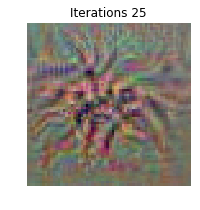

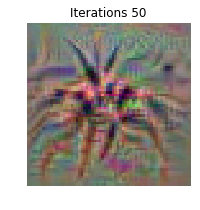

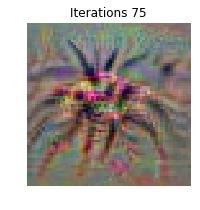

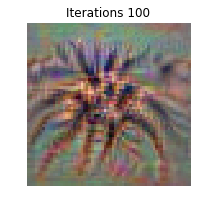

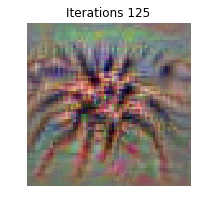

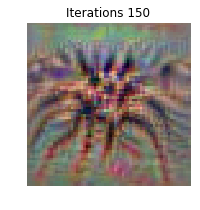

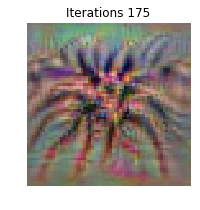

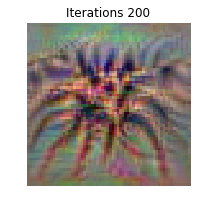

In [26]:
target_y = 43 # Tarantula
print(data['class_names'][target_y])
x = create_class_visualization(target_y, model, show_every = 25, num_iterations = 200)

## Feature Inversion

In [21]:
def invert_features(target_feats, layer, model, **kwargs):
    """
    Perform feature inversion in the style of Mahendran and Vedaldi 2015, using L2 
    regularization and periodic blurring.
    
    Inputs:
    - target_feats: Image features of the targety image of shape (1, C, H, W); we will
      try to generate an image that matches these features;
    - layer: The index of the layer from which the features were extracted;
    - model: A PretrainedCNN that was used to extract features.
    
    Keyword arguments:
    - learning_rate: The learning rate to use for gradient descent;
    - num_iterations: The number of iterations to use for gradient descent;
    - l2_reg: The strength of L2 regularization to use;
    - blur_every: How often to blur the image as implicit regularization; set to 0 to 
      disable blurring;
    - show_every: How often to show the generated image; set to 0 to disable showing 
      intermidiate results.
    
    Returns:
    - x: Generated image of shape (1, 3, 64, 64) that matches the target features.
    """
    learning_rate = kwargs.pop('learning_rate', 10000)
    num_iterations = kwargs.pop('num_iterations', 500)
    l2_reg = kwargs.pop('l2_reg', 1e-7)
    blur_every = kwargs.pop('blur_every', 1)
    show_every = kwargs.pop('show_every', 50)
    
    x = np.random.randn(1, 3, 64, 64)
    for t in range(num_iterations):
        feats, cache = model.forward(x, end = layer)
        loss = np.sum((feats - target_feats) ** 2) + l2_reg * np.sum(x ** 2)
        dfeats = -2 * (target_feats - feats)
        dx, _ = model.backward(dfeats, cache)
        dx += 2 * l2_reg * x
        x -= learning_rate * dx
        
        # As a regularizer, clip the image
        x = np.clip(x, -data['mean_image'], 255.0 - data['mean_image'])
        
        # As a regularizer, periodically blur the image
        if (blur_every > 0) and (t + 1) % blur_every == 0:
            x = blur_image(x)
        
        if (show_every > 0) and (t + 1) % show_every == 0:
            plt.imshow(deprocess_image(x, data['mean_image']))
            plt.gcf().set_size_inches(3, 3)
            plt.axis('off')
            #plt.title('t = %d, loss = %.2f' % (t, loss))
            plt.title('t = %d, loss = %.2f, relative_error = %.2f%%' % 
                      (t + 1, loss, (100 * np.sum((feats - target_feats) ** 2) / np.sum(target_feats ** 2))))
            plt.show()

### Shallow feature reconstruction

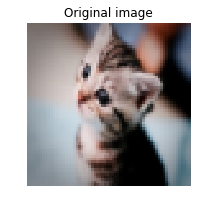

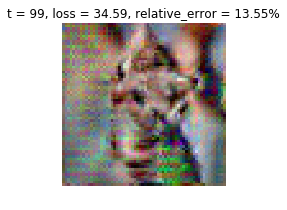

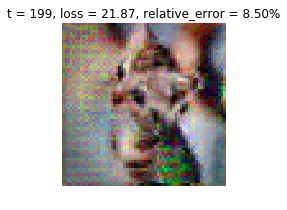

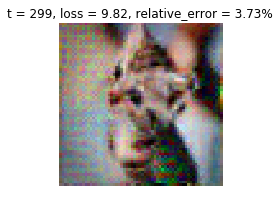

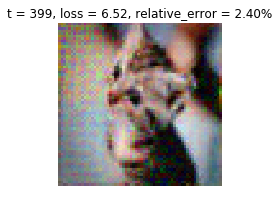

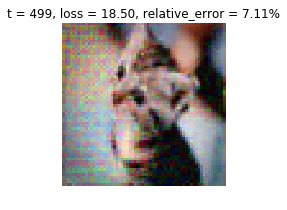

In [22]:
filename = 'kitten.jpg'
layer = 3 # layers start from 0 to these are features after 4 convolutions
img = imresize(imread(filename), (64, 64))

plt.imshow(img)
plt.gcf().set_size_inches(3, 3)
plt.title('Original image')
plt.axis('off')
plt.show()

# Preprocess the image before passing it to the network:
# substract the mean, add a dimension, etc
img_pre = preprocess_image(img, data['mean_image'])

# Extract features from the image
target_feats, _ = model.forward(img_pre, end = layer)

# Invert the features
kwargs = {
    'num_iterations': 500, 
    'learning_rate': 5000, 
    'l2_reg': 1e-8, 
    'show_every': 100,
    'blur_every': 10,
}

x = invert_features(target_feats, layer, model , **kwargs)

### Deep feature reconstruction

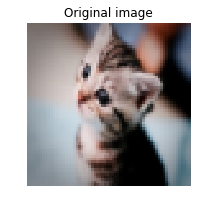

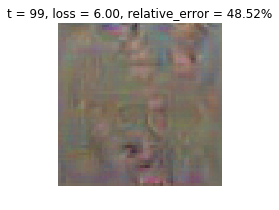

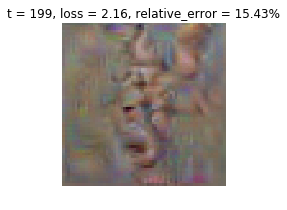

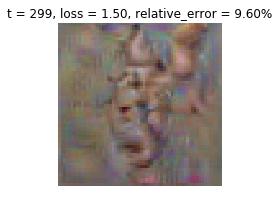

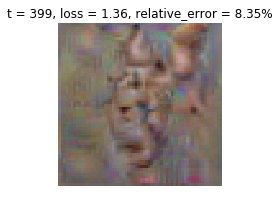

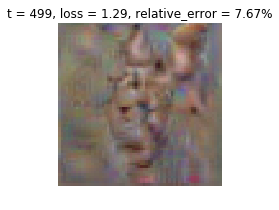

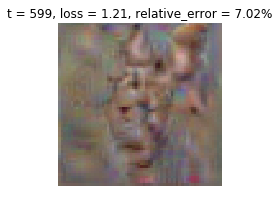

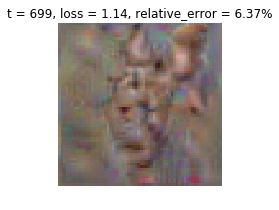

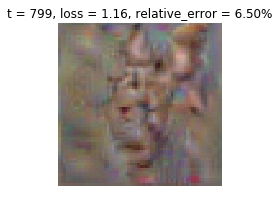

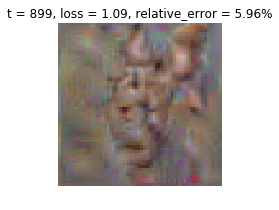

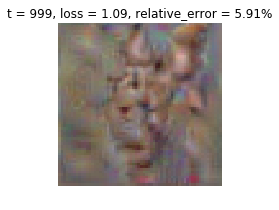

In [23]:
filename = 'kitten.jpg'
layer = 6 # layers start from 0 to these are features after 4 convolutions
img = imresize(imread(filename), (64, 64))

plt.imshow(img)
plt.gcf().set_size_inches(3, 3)
plt.title('Original image')
plt.axis('off')
plt.show()

# Preprocess the image before passing it to the network:
# substract the mean, add a dimension, etc
img_pre = preprocess_image(img, data['mean_image'])

# Extract features from the image
feats_target, _ = model.forward(img_pre, end = layer)

# Invert the features
kwargs = {
    'num_iterations': 1000, 
    'learning_rate': 10000, 
    'l2_reg': 1e-7, 
    'show_every': 100,
    'blur_every': 10,
}

x = invert_features(feats_target, layer, model , **kwargs)

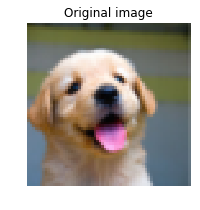

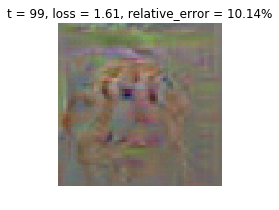

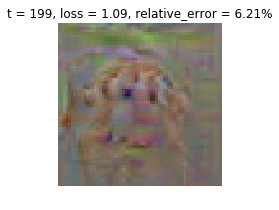

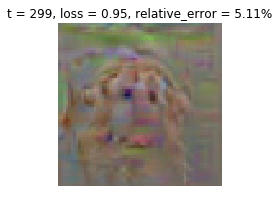

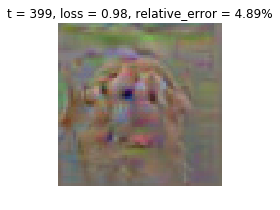

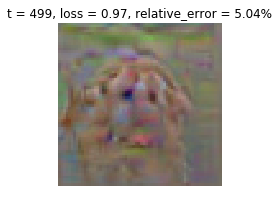

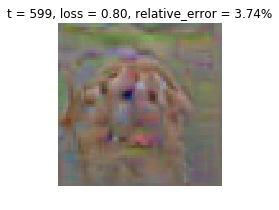

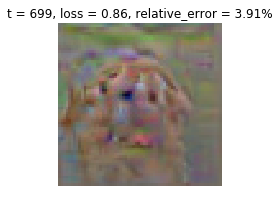

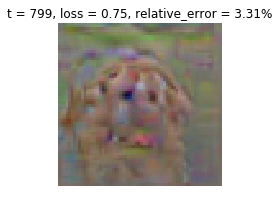

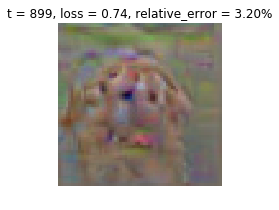

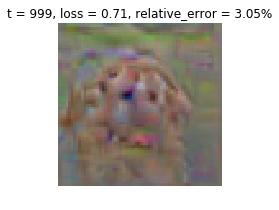

In [24]:
filename = 'puppy.jpg'
layer = 6 # layers start from 0 to these are features after 4 convolutions
img = imresize(imread(filename), (64, 64))

plt.imshow(img)
plt.gcf().set_size_inches(3, 3)
plt.title('Original image')
plt.axis('off')
plt.show()

# Preprocess the image before passing it to the network:
# substract the mean, add a dimension, etc
img_pre = preprocess_image(img, data['mean_image'])

# Extract features from the image
feats_target, _ = model.forward(img_pre, end = layer)

# Invert the features
kwargs = {
    'num_iterations': 1000, 
    'learning_rate': 10000, 
    'l2_reg': 1e-7, 
    'show_every': 100,
    'blur_every': 10,
}

x = invert_features(feats_target, layer, model , **kwargs)

## DeepDream

In [37]:
def deepdream(x, layer, model, **kwargs):
    """
    Generate a DeepDream image.
    
    Inputs:
    - x: Starting image, of shape (1, 3, H, W);
    - layer: Index of layer at which to dream;
    - model: A PretrainedCNN object.
    
    Keyword arguments:
    - learning_rate: How much to update the image at each iteration;
    - max_jitter: Maximum number of pixels for jitter regularization;
    - num_iterations: How many iterations to run for gradient descent;
    - show_every: How often to show the generated image.
    """
    x = x.copy()
    
    learning_rate = kwargs.pop('learning_rate', 5.0)
    max_jitter = kwargs.pop('max_jitter', 16)
    num_iterations = kwargs.pop('num_iterations', 100)
    l2_reg = kwargs.pop('l2_reg', 1e-7)
    show_every = kwargs.pop('show_every', 25)
    
    for t in range(num_iterations):
        # As a regularizer, add random jitter to the image
        ox, oy = np.random.randint(-max_jitter, max_jitter + 1, 2)
        x = np.roll(np.roll(x, ox, -1), oy, -2)
        
        feats, cache = model.forward(x, end = layer)
        dfeats = feats
        dx, _ = model.backward(dfeats, cache)
        dx += l2_reg * x
        x += learning_rate * dx
        
        # Undo the jitter
        x = np.roll(np.roll(x, -ox, -1), -oy, -2)
        
        # As a regularizer, clip the image
        mean_pixel = data['mean_image'].mean(axis = (1, 2), keepdims = True)
        x = np.clip(x, -mean_pixel, 255.0 - mean_pixel)
        
        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0:
            img = deprocess_image(x, data['mean_image'], mean = 'pixel')
            plt.imshow(img)
            plt.title('t = %d' % (t + 1))
            plt.gcf().set_size_inches(8, 8)
            plt.axis ('off')
            plt.show()
    return x

### Generate some images

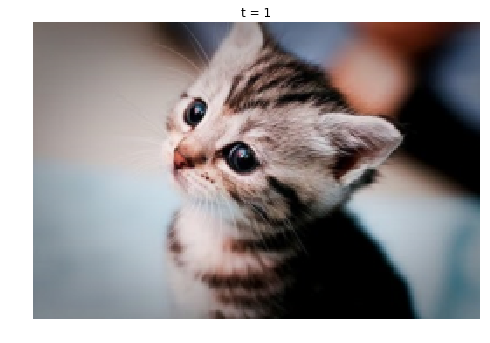

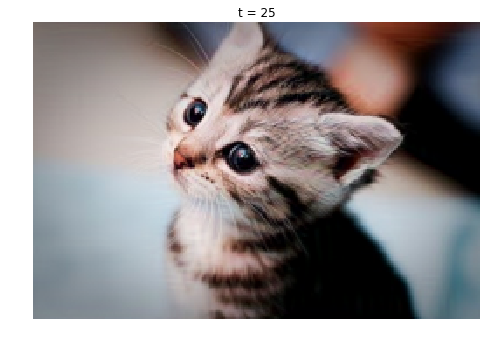

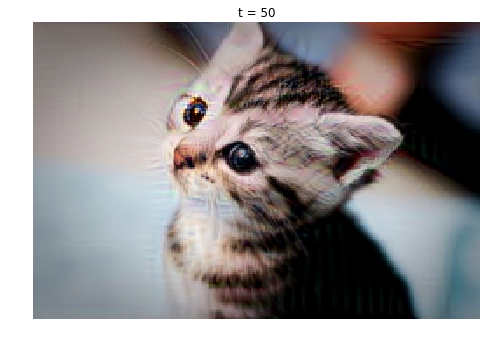

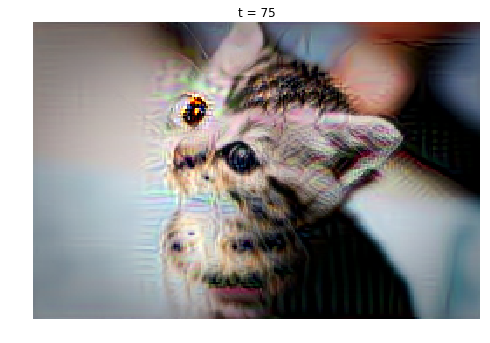

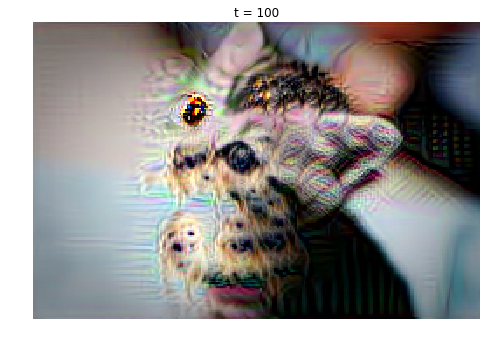

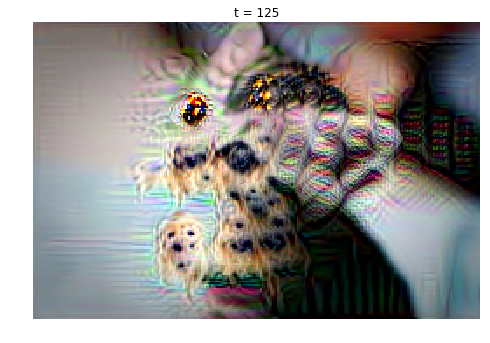

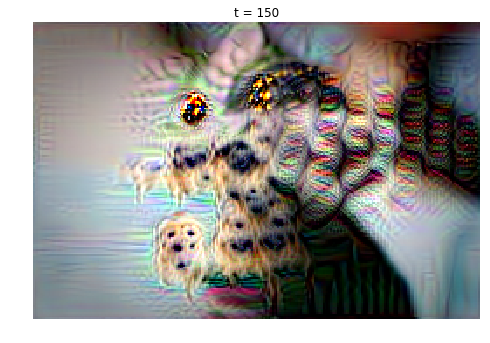

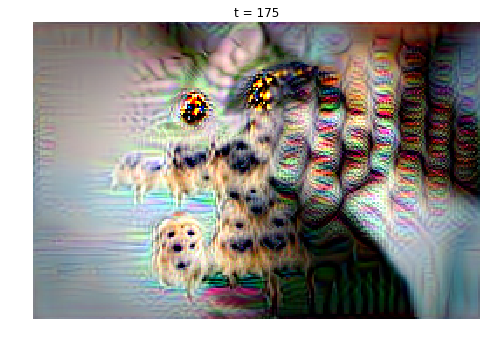

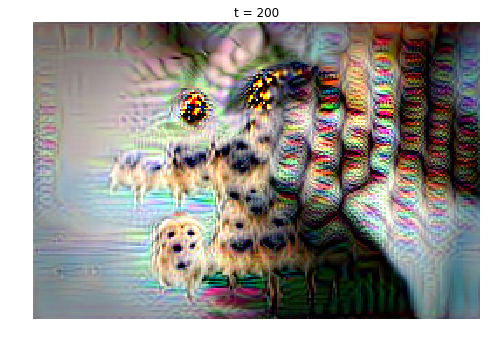

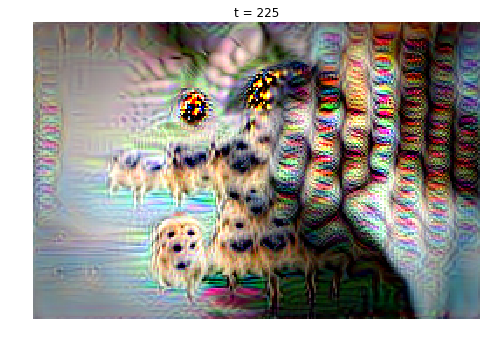

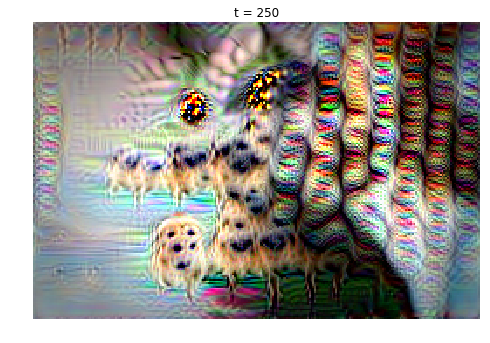

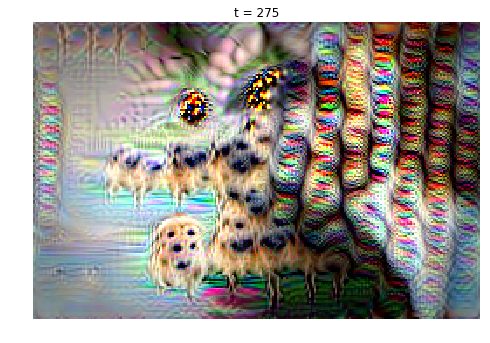

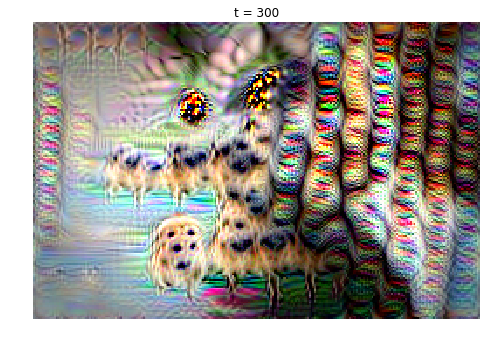

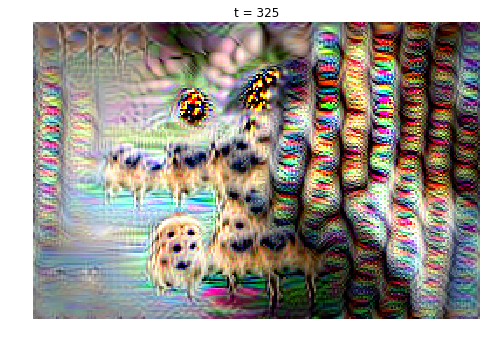

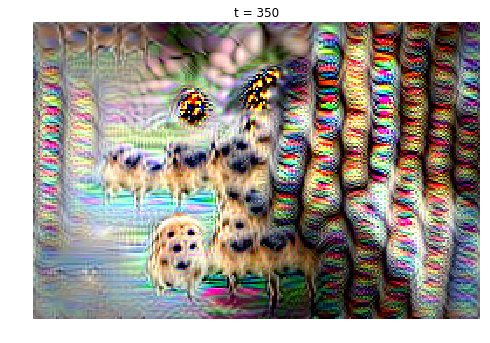

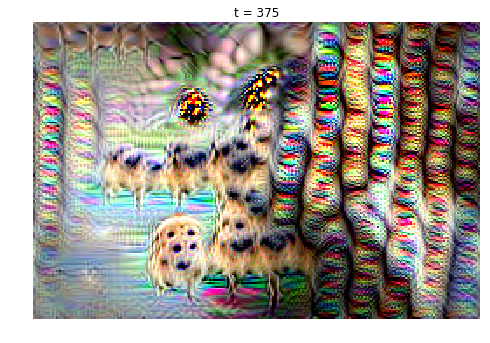

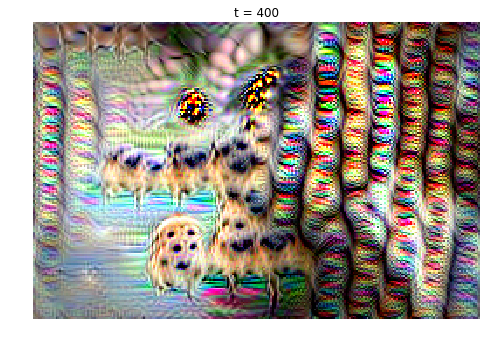

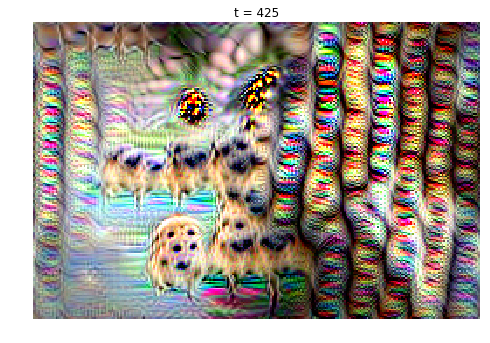

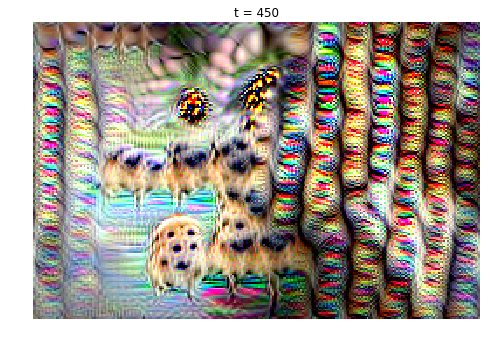

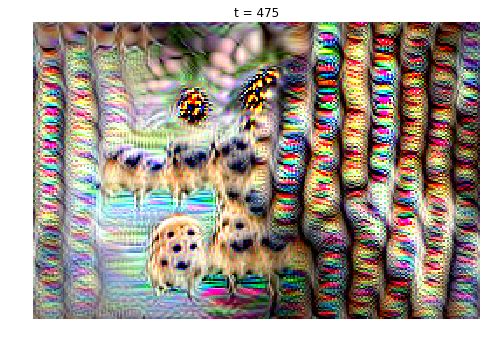

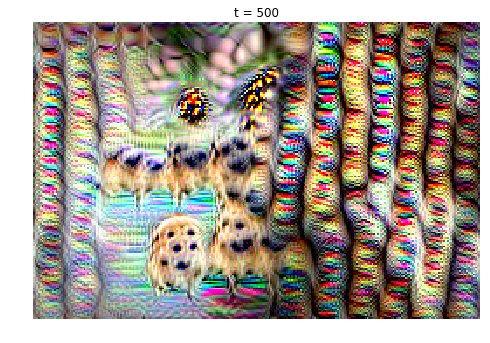

In [38]:
def read_image(filename, max_size):
    """
    Read an image from disk and resize it so its larger side is max_size.
    """
    img = imread(filename)
    H, W, _ = img.shape
    if H > W:
        img = imresize(img, (max_size, int(W * float(max_size) / H)))
    elif H < W:
        img = imresize(img, (int(H * float(max_size) / W), max_size))
    return img

filename = 'kitten.jpg'
max_size = 256
img = read_image(filename, max_size)
plt.imshow(img)
plt.axis('off')

# Preprocess the image by converting to float, trasposing and performing mean substraction.
img_pre = preprocess_image(img, data['mean_image'], mean = 'pixel')
out = deepdream(img_pre, 7, model, learning_rate = 2000, num_iterations = 500)

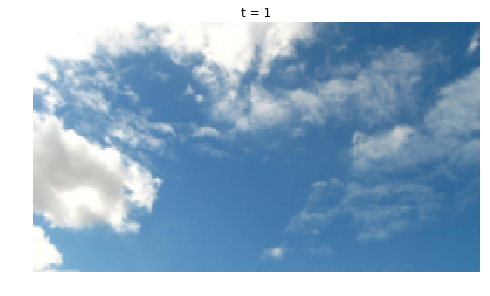

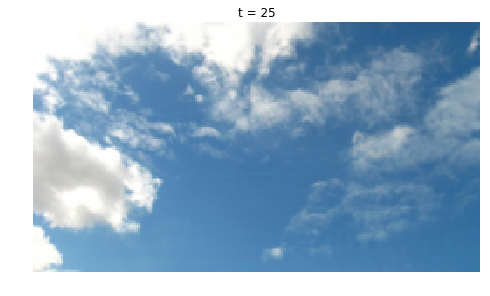

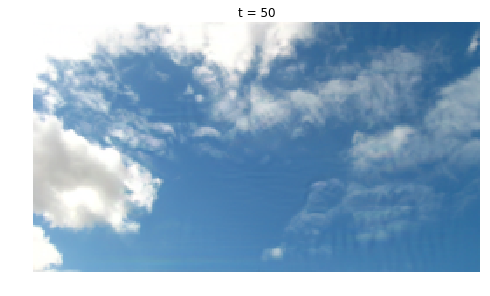

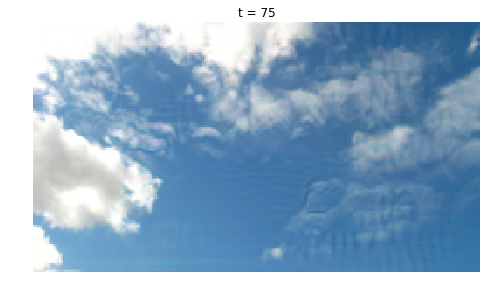

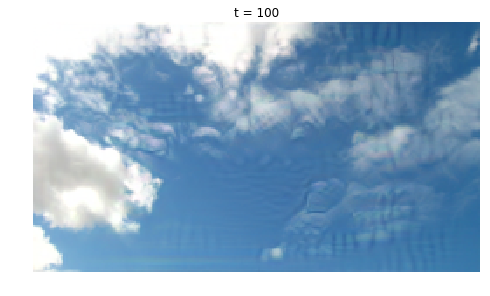

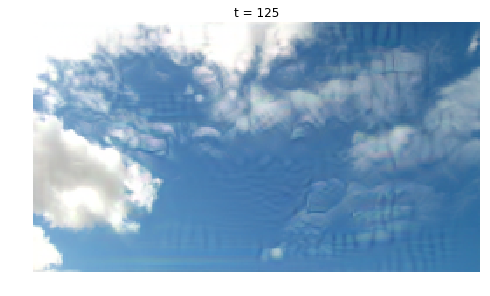

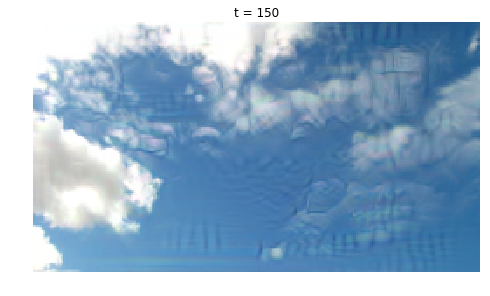

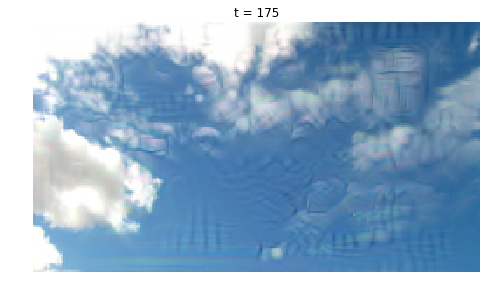

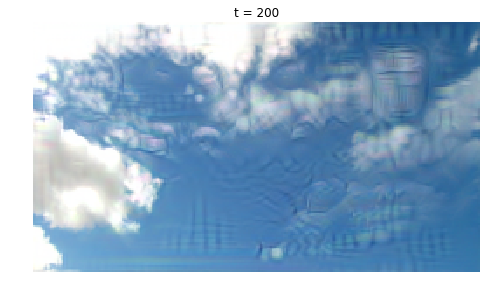

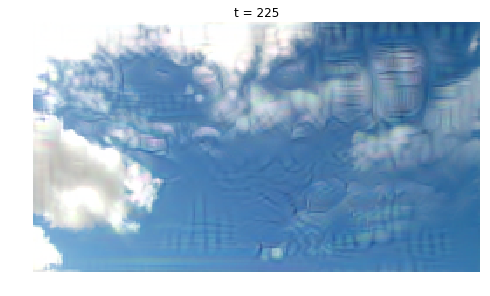

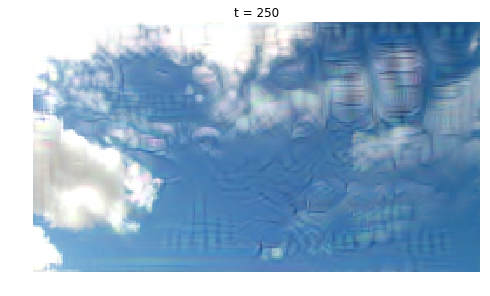

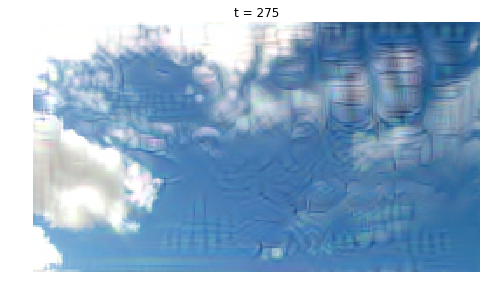

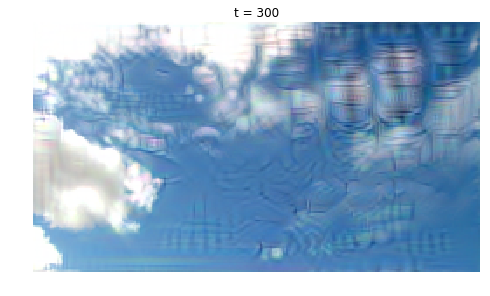

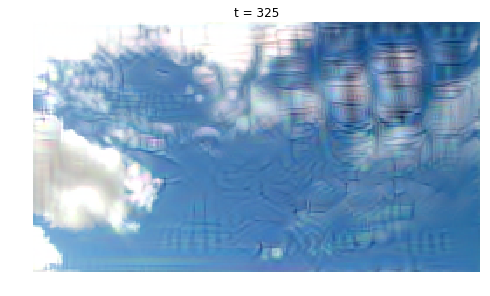

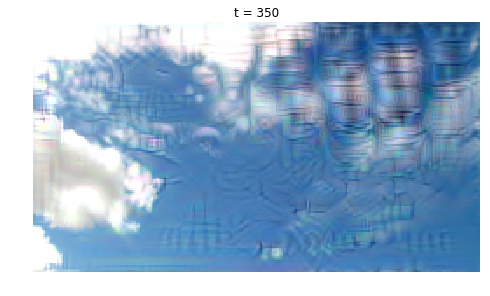

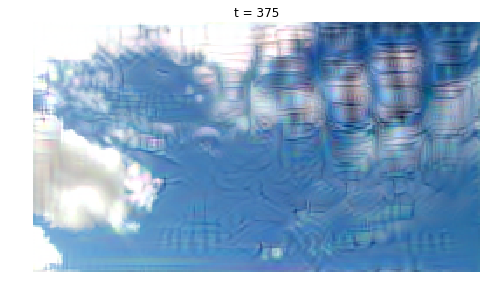

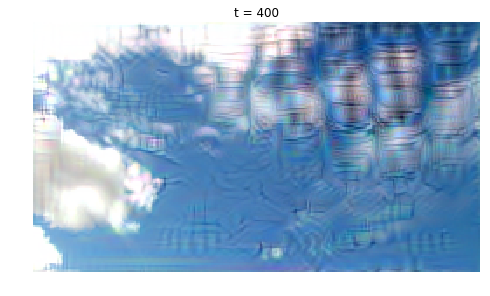

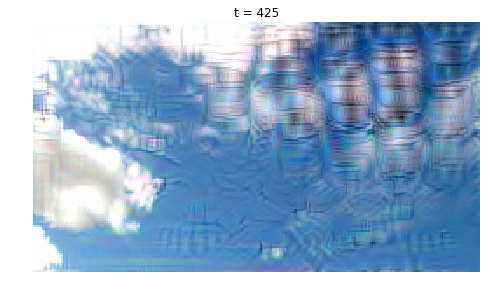

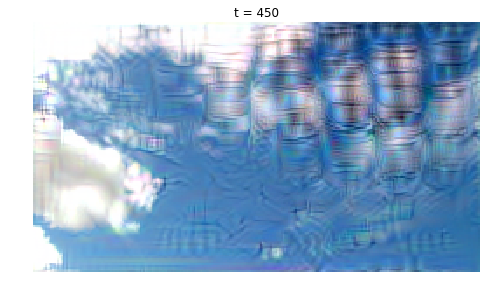

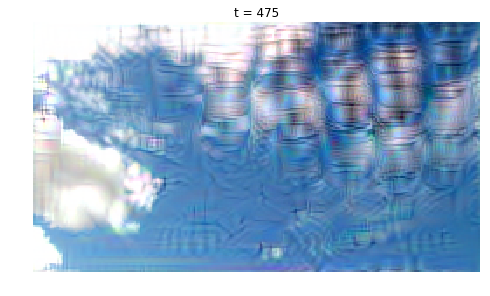

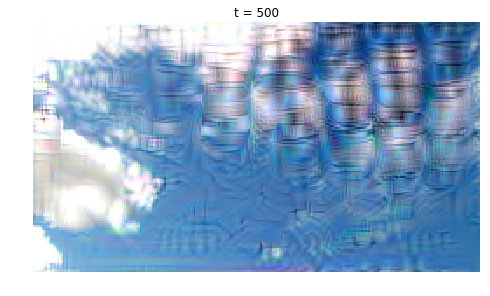

In [44]:
filename = 'sky.jpg'
max_size = 256
img = read_image(filename, max_size)
plt.imshow(img)
plt.axis('off')

# Preprocess the image by converting to float, trasposing and performing mean substraction.
img_pre = preprocess_image(img, data['mean_image'], mean = 'pixel')
out = deepdream(img_pre, 8, model, learning_rate = 2000, num_iterations = 500)